## 处理训练数据

In [19]:
import glob
all_filenames = glob.glob('../../data/names/*.txt')
print(all_filenames)

['../../data/names/Arabic.txt', '../../data/names/Chinese.txt', '../../data/names/Czech.txt', '../../data/names/Dutch.txt', '../../data/names/English.txt', '../../data/names/French.txt', '../../data/names/German.txt', '../../data/names/Greek.txt', '../../data/names/Irish.txt', '../../data/names/Italian.txt', '../../data/names/Japanese.txt', '../../data/names/Korean.txt', '../../data/names/Polish.txt', '../../data/names/Portuguese.txt', '../../data/names/Russian.txt', '../../data/names/Scottish.txt', '../../data/names/Spanish.txt', '../../data/names/Vietnamese.txt']


In [20]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    '''
        将特别字母转为26个字母
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))
print('all_letters: {}, and length: {}'.format(all_letters, len(all_letters)))


Slusarski
all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;', and length: 57


In [21]:
category_lines = {}
all_categories = []

def readLines(filename):
    '''
        逐行读取姓名，并转为ASCII
    '''
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
print('all_categories: ', all_categories)
print('n_categories = ', n_categories)    

all_categories:  ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
n_categories =  18


In [22]:
all_line_num = 0
for key in category_lines:
    all_line_num += len(category_lines[key])
print(all_line_num)

20074


In [23]:
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

%matplotlib inline

In [24]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_index = all_categories.index(category)
    line_index = [all_letters.index(letter) for letter in line]
    return category, line, category_index, line_index

for i in range(5):
    category, line, category_index, line_index = random_training_pair()
    print('category = ', category, ' / line = ', line)
    print('category = ', category_index, '/ line = ', line_index)

category =  Chinese  / line =  Yan
category =  1 / line =  [50, 0, 13]
category =  Spanish  / line =  Silva
category =  16 / line =  [44, 8, 11, 21, 0]
category =  Dutch  / line =  Althuis
category =  3 / line =  [26, 11, 19, 7, 20, 8, 18]
category =  English  / line =  Hubbard
category =  4 / line =  [33, 20, 1, 1, 0, 17, 3]
category =  Czech  / line =  Ballalatak
category =  2 / line =  [27, 0, 11, 11, 0, 11, 0, 19, 0, 10]


In [25]:
def category_from_output(output):
    '''
    它可以把网络的输出（1 x 18的张量）转化成“最可能的语言类别”，这就需要找到18列数据中哪个概率值最大。
    我们可以使用 `Tensor.topk` 方法来得到数据中最大值位置的索引。
    '''
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

## 写LSTM模型

In [26]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, 18)
        self.logsoftmax = nn.LogSoftmax()
        
    def forward(self, input, hidden=None):
        embedded = self.embedding(input)
        
        embedded = embedded.view(input.data.size()[0], 1, self.hidden_size)
        
        output, hidden = self.lstm(embedded, hidden)
        
        output = output[-1, ...]
        
        out = self.fc(output)
        out= self.logsoftmax(out)
        return out
    def initHidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        cell = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        return (hidden, cell)

## 训练网络

In [27]:
import time
import math

n_epochs = 100000
lstm = LSTMNetwork(n_letters, 10, n_categories, 2)

cost = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)

In [28]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
records = []
losses = []
for epoch in range(5):
    losses = []
    for i in range(all_line_num):
        category, line, y, x = random_training_pair()
        x = Variable(torch.LongTensor(x))
        y = Variable(torch.LongTensor(np.array([y])))
        optimizer.zero_grad()
        
        hidden = lstm.initHidden()
        output = lstm(x, hidden)
        loss = cost(output, y)
        losses.append(loss.data.numpy()[0])
        
        loss.backward()
        optimizer.step()
        
        if i % 3000 == 0:
            guess, guess_i = category_from_output(output)
            correct = '✅' if  guess == category else '❌(%s)' % category
            training_process = (all_line_num * epoch  + i) / (all_line_num * 5) * 100
            training_process = '%.2f' % training_process
            
            print('第{}轮, 训练损失: {:.2f}, 训练进度: {}%, ({}), 名字： {}， 预测国家： {}, 正确？ {}'\
                 .format(epoch, np.mean(losses), float(training_process), time_since(start), line, guess, correct))
            
            records.append([np.mean(losses)])

第0轮, 训练损失: 2.86, 训练进度: 0.0%, (0m 0s), 名字： Safar， 预测国家： Russian, 正确？ ❌(Arabic)
第0轮, 训练损失: 2.76, 训练进度: 2.99%, (1m 24s), 名字： Watt， 预测国家： Polish, 正确？ ❌(Scottish)
第0轮, 训练损失: 2.54, 训练进度: 5.98%, (2m 23s), 名字： Geroux， 预测国家： Portuguese, 正确？ ❌(French)
第0轮, 训练损失: 2.39, 训练进度: 8.97%, (3m 25s), 名字： Mingo， 预测国家： Polish, 正确？ ❌(Spanish)
第0轮, 训练损失: 2.28, 训练进度: 11.96%, (4m 28s), 名字： Fortier， 预测国家： German, 正确？ ❌(French)
第0轮, 训练损失: 2.20, 训练进度: 14.94%, (5m 25s), 名字： Laar， 预测国家： Arabic, 正确？ ❌(Dutch)
第0轮, 训练损失: 2.13, 训练进度: 17.93%, (6m 22s), 名字： Mcmillan， 预测国家： Scottish, 正确？ ✅
第1轮, 训练损失: 2.55, 训练进度: 20.0%, (7m 1s), 名字： Sulzbach， 预测国家： Russian, 正确？ ❌(German)
第1轮, 训练损失: 1.70, 训练进度: 22.99%, (7m 59s), 名字： Jin， 预测国家： Korean, 正确？ ❌(Chinese)
第1轮, 训练损失: 1.70, 训练进度: 25.98%, (8m 53s), 名字： Krhovsky， 预测国家： Russian, 正确？ ❌(Czech)
第1轮, 训练损失: 1.67, 训练进度: 28.97%, (9m 53s), 名字： Kouba， 预测国家： Japanese, 正确？ ❌(Czech)
第1轮, 训练损失: 1.65, 训练进度: 31.96%, (10m 52s), 名字： Leroy， 预测国家： Scottish, 正确？ ❌(French)
第1轮, 训练损失: 1.63, 训练进度: 34.94%, (1

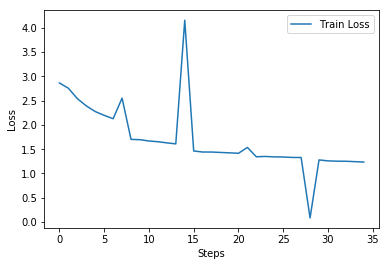

In [29]:
a = [i[0] for i in records]
plt.plot(a, label='Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

/Users/mac/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type LSTMNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


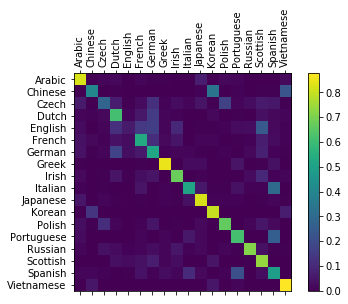


> Dovesky
(-0.26) Russian
(-2.33) Polish
(-2.63) Czech

> Jackson
(-0.62) Scottish
(-1.85) English
(-2.66) Dutch

> Satoshi
(-0.05) Japanese
(-3.65) Arabic
(-4.64) Portuguese

> Han
(-1.10) Vietnamese
(-1.20) Korean
(-1.78) Chinese


In [31]:
torch.save(lstm, 'lstm.mdl')
lstm = torch.load('lstm.mdl')

import matplotlib.pyplot as plt

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_list):
    hidden = lstm.initHidden()
    line_variable = Variable(torch.LongTensor(line_list))
    output = lstm(line_variable, hidden)
    return output

for i in range(n_confusion):
    category, line, category_index, line_list = random_training_pair()
    output = evaluate(line_list)
    guess, guess_i = category_from_output(output)
    confusion[category_index][guess_i] += 1
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


def predict(input_line, n_predictions = 3):
    print('\n> %s' % input_line)
    input_line = list(map(lambda x: all_letters.find(x), input_line))
    output = evaluate(input_line)
    
    topv, topi = output.data.topk(n_predictions, 1, True)
    
    predictions = []
    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])
        
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Han')